# Paddle动态图卷积模型Filter剪裁教程

该教程以MobileNetV1模型和Cifar10分类任务为例，介绍如何使用PaddleSlim对动态图卷积模型进行filter剪裁。

## 1. 模型定义

PaddlePaddle提供的`vision`模块提供了一些构建好的分类模型结构，并提供在`ImageNet`数据集上的预训练模型。为了简化教程，我们不再重新定义网络结构，而是直接从`vision`模块导入模型结构。代码如下所示，我们导入`MobileNetV1`模型，并查看模型的结构信息。

In [1]:

import paddle
from paddle.vision.models import mobilenet_v1
net = mobilenet_v1(pretrained=False)
paddle.summary(net, (1, 3, 32, 32))

---------------------------------------------------------------------------------
    Layer (type)          Input Shape          Output Shape         Param #    
      Conv2D-1          [[1, 3, 32, 32]]     [1, 32, 16, 16]          864      
    BatchNorm2D-1      [[1, 32, 16, 16]]     [1, 32, 16, 16]          128      
       ReLU-1          [[1, 32, 16, 16]]     [1, 32, 16, 16]           0       
    ConvBNLayer-1       [[1, 3, 32, 32]]     [1, 32, 16, 16]           0       
      Conv2D-2         [[1, 32, 16, 16]]     [1, 32, 16, 16]          288      
    BatchNorm2D-2      [[1, 32, 16, 16]]     [1, 32, 16, 16]          128      
       ReLU-2          [[1, 32, 16, 16]]     [1, 32, 16, 16]           0       
    ConvBNLayer-2      [[1, 32, 16, 16]]     [1, 32, 16, 16]           0       
      Conv2D-3         [[1, 32, 16, 16]]     [1, 64, 16, 16]         2,048     
    BatchNorm2D-3      [[1, 64, 16, 16]]     [1, 64, 16, 16]          256      
       ReLU-3          [[1, 64, 16, 16

{'total_params': 4253864, 'trainable_params': 4210088}

## 2. 准备数据

我们直接使用`vision`模块提供的`Cifar10`数据集，并通过飞桨高层API `paddle.vision.transforms`对数据进行预处理。在声明`paddle.vision.datasets.Cifar10`对象时，会自动下载数据并缓存到本地文件系统。代码如下所示：

In [2]:
import paddle.vision.transforms as T
transform = T.Compose([
                    T.Transpose(),
                    T.Normalize([127.5], [127.5])
                ])
train_dataset = paddle.vision.datasets.Cifar10(mode="train", backend="cv2",transform=transform)
val_dataset = paddle.vision.datasets.Cifar10(mode="test", backend="cv2",transform=transform)

/root/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


我们可以通过以下代码查看训练集和测试集的样本数量，并尝试取出训练集中的第一个样本，观察其图片的`shape`和对应的`label`。

In [3]:
from __future__ import print_function
print(f'train samples count: {len(train_dataset)}')
print(f'val samples count: {len(val_dataset)}')
for data in train_dataset:
    print(f'image shape: {data[0].shape}; label: {data[1]}')
    break

train samples count: 50000
val samples count: 10000
image shape: (3, 32, 32); label: 0


## 3. 模型训练准备工作

在对卷积网络进行剪裁之前，我们需要在测试集上评估网络中各层的重要性。在剪裁之后，我们需要对得到的小模型进行重训练。在本示例中，我们将会使用Paddle高层API `paddle.Model`进行训练和评估工作。以下代码声明了`paddle.Model`实例，并指定了训练相关的一些设置，包括：
- 输入的shape
- 优化器
- 损失函数
- 模型评估指标

In [4]:
from paddle.static import InputSpec as Input
optimizer = paddle.optimizer.Momentum(
        learning_rate=0.1,
        parameters=net.parameters())

inputs = [Input([None, 3, 224, 224], 'float32', name='image')]
labels = [Input([None, 1], 'int64', name='label')]

model = paddle.Model(net, inputs, labels)
    
model.prepare(
        optimizer,
        paddle.nn.CrossEntropyLoss(),
        paddle.metric.Accuracy(topk=(1, 5)))

以上代码声明了用于训练的`model`对象，接下来可以调用`model`的`fit`接口和`evaluate`接口分别进行训练和评估：

In [5]:
model.fit(train_dataset, epochs=2, batch_size=128, verbose=1)

Epoch 1/2


/root/miniconda3/lib/python3.8/site-packages/paddle/fluid/layers/utils.py:77: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  return (isinstance(seq, collections.Sequence) and
/root/miniconda3/lib/python3.8/site-packages/paddle/nn/layer/norm.py:636: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step   391/50000 [..............................] - loss: 1.5186 - acc_top1: 0.3413 - acc_top5: 0.8384 - ETA: 32:51 - 40ms/stepEpoch 2/2
step   391/50000 [..............................] - loss: 1.5569 - acc_top1: 0.4744 - acc_top5: 0.9177 - ETA: 30:44 - 37ms/step

In [6]:
result = model.evaluate(val_dataset,batch_size=128, log_freq=10)
print(result)

Eval begin...
step    10/10000 - loss: 1.3962 - acc_top1: 0.5188 - acc_top5: 0.9383 - 31ms/step
step    20/10000 - loss: 1.5611 - acc_top1: 0.5125 - acc_top5: 0.9371 - 28ms/step
step    30/10000 - loss: 1.2924 - acc_top1: 0.5141 - acc_top5: 0.9302 - 26ms/step
step    40/10000 - loss: 1.3531 - acc_top1: 0.5176 - acc_top5: 0.9311 - 25ms/step
step    50/10000 - loss: 1.3971 - acc_top1: 0.5136 - acc_top5: 0.9303 - 24ms/step
step    60/10000 - loss: 1.5635 - acc_top1: 0.5105 - acc_top5: 0.9316 - 25ms/step
step    70/10000 - loss: 1.3301 - acc_top1: 0.5095 - acc_top5: 0.9300 - 25ms/step
step    79/10000 - loss: 1.3801 - acc_top1: 0.5121 - acc_top5: 0.9306 - 24ms/step
Eval samples: 10000
{'loss': [1.3800987], 'acc_top1': 0.5121, 'acc_top5': 0.9306}


## 4. 剪裁

本节内容分为两部分：卷积层重要性分析和`Filters`剪裁，其中『卷积层重要性分析』也可以被称作『卷积层敏感度分析』，我们定义越重要的卷积层越敏感。
PaddleSlim提供了工具类`Pruner`来进行重要性分析和剪裁操作，不同的`Pruner`的子类对应不同的分析和剪裁策略，本示例以`L1NormFilterPruner`为例说明。首先我们声明一个`L1NormFilterPruner`对象，如下所示：

In [7]:
from paddleslim.dygraph import L1NormFilterPruner
pruner = L1NormFilterPruner(net, [1, 3, 224, 224])#, sen_file="./sen.pickle")

/root/miniconda3/lib/python3.8/site-packages/paddle/fluid/framework.py:151: UserWarning: PaddlePaddle version 1.8.4 or higher is required, but 0.0.0 installed, Maybe you are using a develop version, please make sure the version is good with your code.
  warnings.warn(
2020-11-23 11:10:28,277-INFO: Parsing model with input: [1, 3, 224, 224]


src : None


2020-11-23 11:10:28,696-INFO: No walker for operator: matmul
2020-11-23 11:10:28,710-INFO: Found 14 groups.
2020-11-23 11:10:28,711-INFO: Parsing model with input: [1, 3, 224, 224]
2020-11-23 11:10:29,145-INFO: No walker for operator: matmul
2020-11-23 11:10:29,157-INFO: Found 14 groups.



### 4.1 卷积重要性分析

在对卷积网络中的filters进行剪裁时，我们需要判断哪些`filters`不重要，然后优先剪掉不重要的`filters`。
在一个卷积内，我们使用`filter`的`L1 Norm`来代表重要性，`L1 Norm`越大的`filters`越重要。在多个卷积间，我们通过敏感度代表卷积的重要性，越敏感的卷积越重要，重要的卷积会被剪掉相对较少的`filters`。
单个卷积内的filters重要性计算会在剪裁时进行，无需用户关注。本小节，我们只介绍多个卷积间如何分析重要性，即『敏感度分析』。

#### 敏感度定义

如图4-1所示，某个卷积网络包含K个卷积层，每个卷积层有4个`filters`，原始网络精度为90。

第一步：从『卷积1』中剪裁掉25%的filters，也就是『卷积1』中第2个Filters，然后直接在测试集上评估精度结果为85，得到左边坐标图的第二个红点。恢复模型到初始状态。
第二步：从『卷积1』中裁掉2个卷积，然后在测试集上评估精度为70，得到坐标图的第3个红点。恢复模型到初始状态。
第三步：同理得到第4个红点。把『卷积1』对应的4个红点链接成曲线，即为『卷积1』的敏感度曲线。
第四步：同理得到『卷积K』的敏感度曲线。

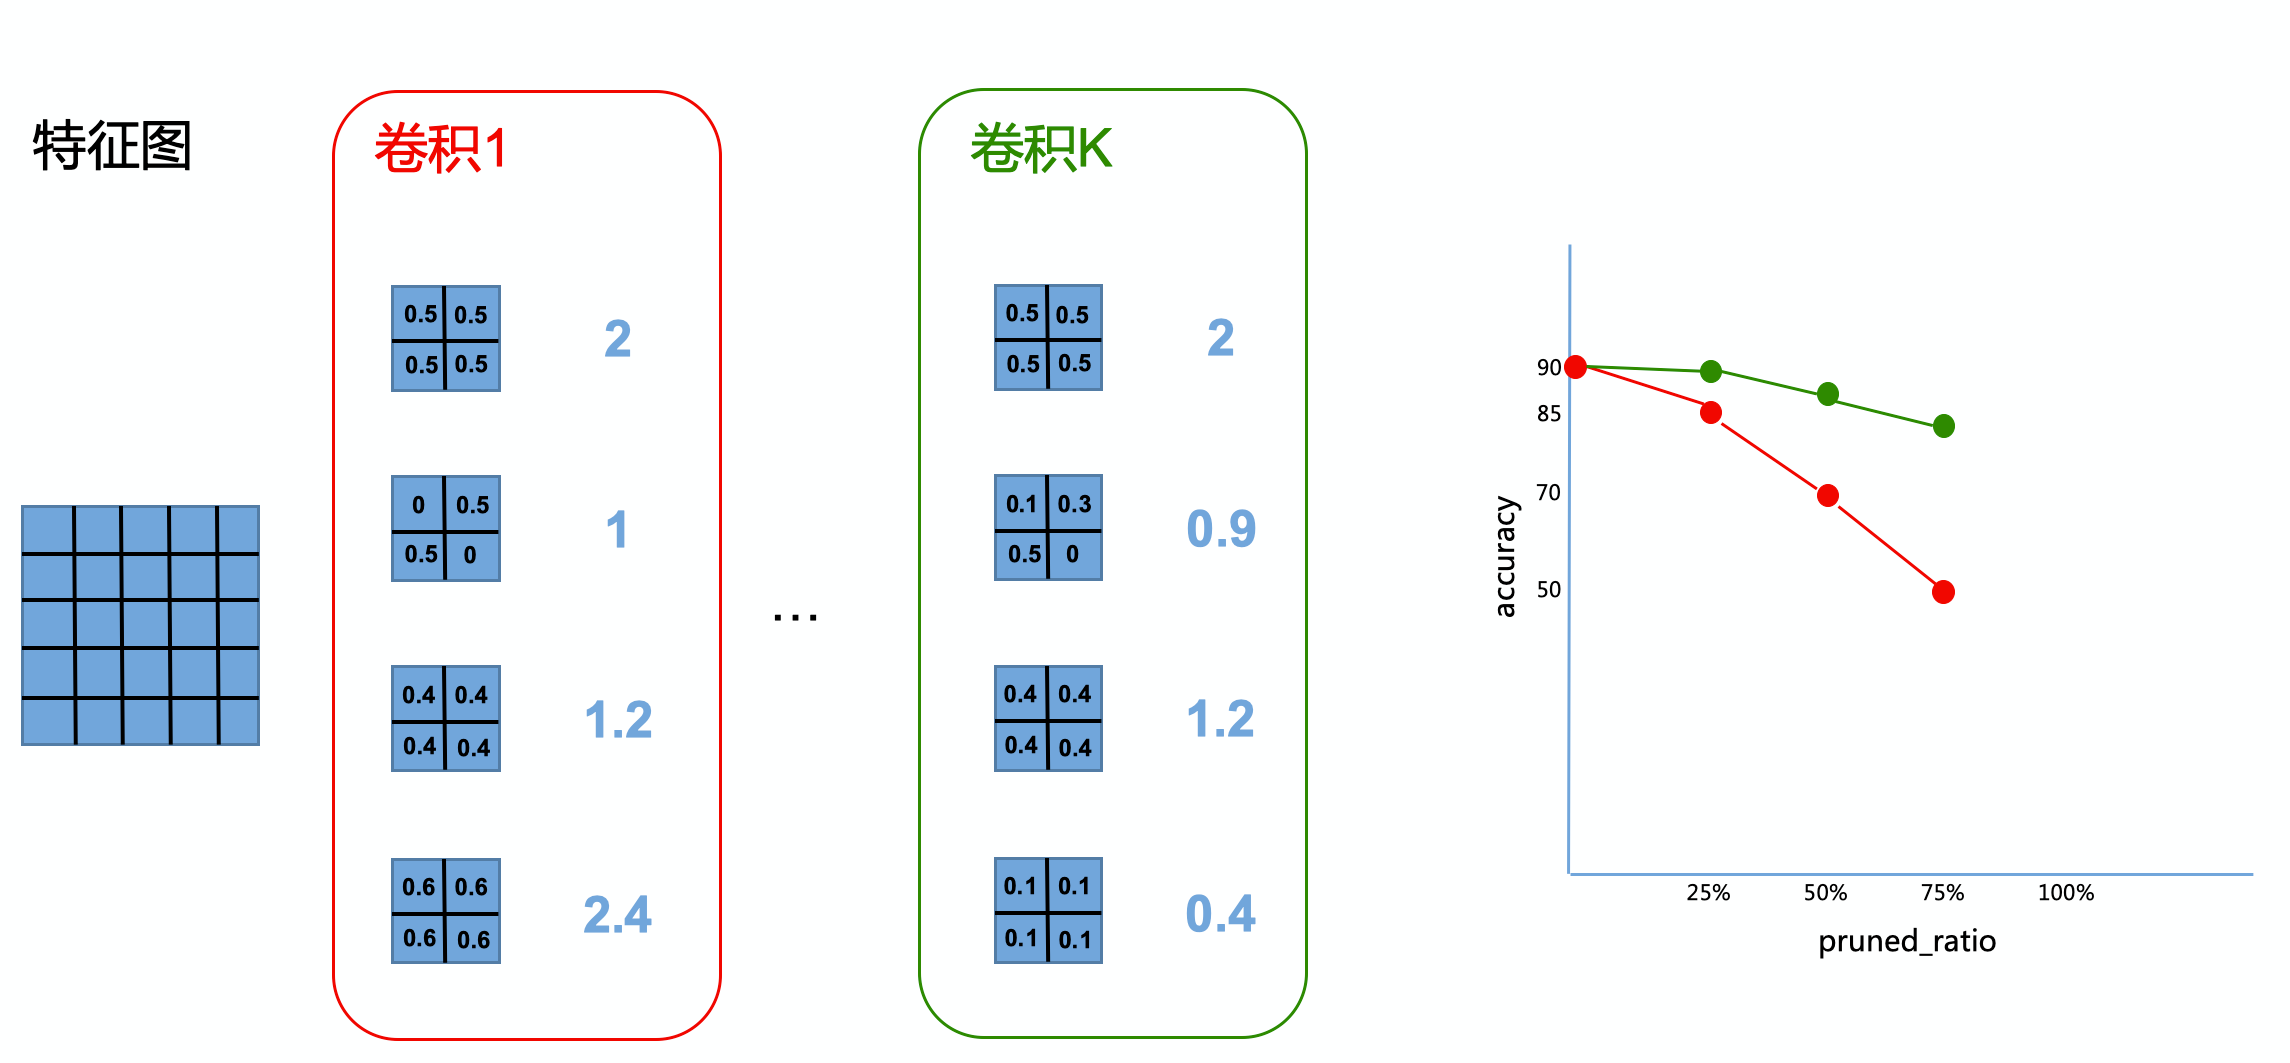

<center>图4-1 敏感度计算过程示意图

如图4-2所示，为VGG-16在CIFAR10分类任务上的敏感度曲线示意图：

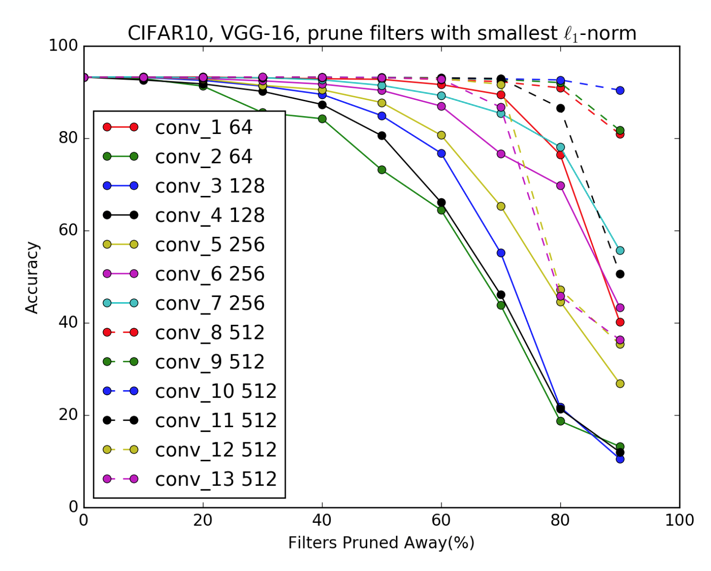

<center>图4-2 VGG-16敏感度示例
    
考虑到不同的模型在不同的任务上的精度数值差别较大，甚至不在同一个量级，所以，PaddleSlim在计算和存储卷积层敏感度时，使用的是精度的损失比例。如图4-3所示，为PaddleSlim计算出的MobileNetV1-YOLOv3在VOC检测任务上的敏感度示意图，其中，纵轴为精度损失：

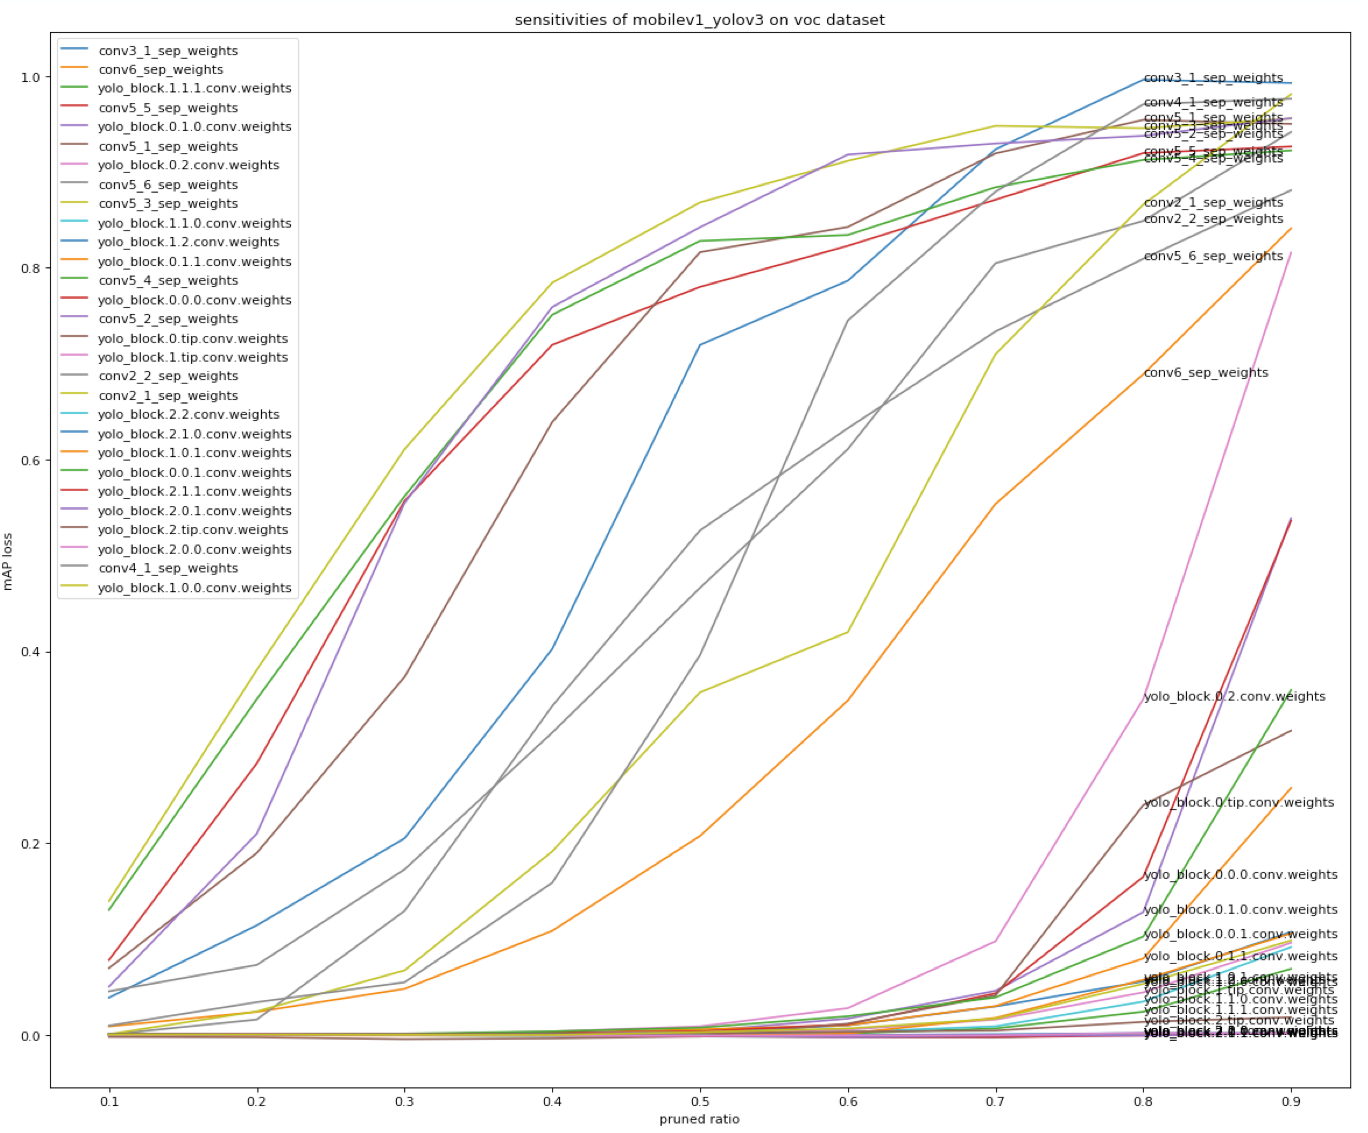
<center>图4-3 用精度损失表示的敏感度<\center>


#### 敏感度计算

调用`pruner`对象的`sensitive`方法进行敏感度分析，在调用`sensitive`之前，我们简单对`model.evaluate`进行包装，使其符合`sensitive`接口的规范。执行如下代码，会进行敏感度计算，并将计算结果存入本地文件系统：

In [8]:
def eval_fn():
        result = model.evaluate(
            val_dataset,
            batch_size=128)
        return result['acc_top1']
sen = pruner.sensitive(eval_func=eval_fn, sen_file="./sen.pickle")

/root/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-11-23 11:10:29,165-INFO: Load status from ./sen.pickle


Eval begin...
step    10/10000 - loss: 1.3962 - acc_top1: 0.5188 - acc_top5: 0.9383 - 28ms/step
step    20/10000 - loss: 1.5611 - acc_top1: 0.5125 - acc_top5: 0.9371 - 26ms/step
step    30/10000 - loss: 1.2924 - acc_top1: 0.5141 - acc_top5: 0.9302 - 27ms/step
step    40/10000 - loss: 1.3531 - acc_top1: 0.5176 - acc_top5: 0.9311 - 27ms/step
step    50/10000 - loss: 1.3971 - acc_top1: 0.5136 - acc_top5: 0.9303 - 25ms/step
step    60/10000 - loss: 1.5635 - acc_top1: 0.5105 - acc_top5: 0.9316 - 25ms/step
step    70/10000 - loss: 1.3301 - acc_top1: 0.5095 - acc_top5: 0.9300 - 25ms/step
step    79/10000 - loss: 1.3801 - acc_top1: 0.5121 - acc_top5: 0.9306 - 25ms/step
Eval samples: 10000


上述代码执行完毕后，敏感度信息会存放在pruner对象中，可以通过以下方式查看敏感度信息内容：

In [9]:
print(pruner.sensitive())

{'conv2d_0.w_0': {0.1: 0.017385968500715908, 0.2: 0.14583759460012266, 0.3: 0.7091429740233177, 0.4: 0.7238699120474534, 0.5: 0.7457557782777665, 0.6: 0.7492329719779096, 0.7: 0.7371650644303539, 0.8: 0.8075271016567805, 0.9: 0.7752096543260381}, 'conv2d_2.w_0': {0.1: 0.009408877070975645, 0.2: 0.035999181836776445, 0.3: 0.14706483943546741, 0.4: 0.24688075271016563, 0.5: 0.4542851298834118, 0.6: 0.5909183882184496, 0.7: 0.6173041521783597, 0.8: 0.5972591532010637, 0.9: 0.718756391900184}, 'conv2d_4.w_0': {0.1: -0.004090816117815508, 0.2: 0.014726938024135782, 0.3: 0.03824913070157495, 0.4: 0.07465739415013291, 0.5: 0.1617917774596032, 0.6: 0.23031294743301284, 0.7: 0.371241562691757, 0.8: 0.47596645530783394, 0.9: 0.7005522601759051}, 'conv2d_6.w_0': {0.1: 0.011863366741665018, 0.2: 0.03027203927183469, 0.3: 0.04213540601349971, 0.4: 0.05011249744323997, 0.5: 0.1159746369400696, 0.6: 0.2356310083861731, 0.7: 0.30169768868889346, 0.8: 0.42544487625281247, 0.9: 0.5976682348128451}, 'con

### 4.2 剪裁

`pruner`对象提供了`sensitive_prune`方法根据敏感度信息对模型进行剪裁，用户只需要传入期望的FLOPs减少比例。首先，我们记录下剪裁之前的模型的FLOPs数值，如下：

In [10]:
from paddleslim.analysis import dygraph_flops
flops = dygraph_flops(net, [1, 3, 32, 32])
print(f"FLOPs before pruning: {flops}")

FLOPs before pruning: 11792896.0


执行剪裁操作，期望跳过最后一层卷积层并剪掉40%的FLOPs：

In [11]:
plan = pruner.sensitive_prune(0.4, skip_vars=["conv2d_26.w_0"])
flops = dygraph_flops(net, [1, 3, 32, 32])
print(f"FLOPs after pruning: {flops}")
print(f"Pruned FLOPs: {round(plan.pruned_flops*100, 2)}%")

2020-11-23 11:10:31,175-INFO: skip vars: ['conv2d_26.w_0', 'conv2d_1.w_0', 'conv2d_3.w_0', 'conv2d_5.w_0', 'conv2d_7.w_0', 'conv2d_9.w_0', 'conv2d_11.w_0', 'conv2d_13.w_0', 'conv2d_15.w_0', 'conv2d_17.w_0', 'conv2d_19.w_0', 'conv2d_21.w_0', 'conv2d_23.w_0', 'conv2d_25.w_0']
2020-11-23 11:10:31,200-INFO: Base FLOPs: 577802752.0
2020-11-23 11:10:35,306-INFO: ratios: {'conv2d_0.w_0': 0.11601995966237062, 'conv2d_2.w_0': 0.20176894045666438, 'conv2d_4.w_0': 0.298787257982337, 'conv2d_6.w_0': 0.2648368046201509, 'conv2d_8.w_0': 0.21372403876726023, 'conv2d_10.w_0': 0.33923762394831725, 'conv2d_12.w_0': 0.1863417934363995, 'conv2d_14.w_0': 0.11795758334073145, 'conv2d_16.w_0': 0.13510066013710165, 'conv2d_20.w_0': 0.11478426915518253, 'conv2d_22.w_0': 0.5602427225626871, 'conv2d_24.w_0': 0.7491984751032688}


FLOPs after pruning: 7082985.0
Pruned FLOPs: 39.94%


剪裁之后，在测试集上重新评估精度，会发现精度大幅下降，如下所示：

In [12]:
result = model.evaluate(val_dataset,batch_size=128, log_freq=10)
print(f"before fine-tuning: {result}")

Eval begin...
step    10/10000 - loss: 2.4331 - acc_top1: 0.0953 - acc_top5: 0.5578 - 25ms/step
step    20/10000 - loss: 2.3753 - acc_top1: 0.1082 - acc_top5: 0.5648 - 24ms/step
step    30/10000 - loss: 2.2521 - acc_top1: 0.1135 - acc_top5: 0.5729 - 25ms/step
step    40/10000 - loss: 2.3409 - acc_top1: 0.1131 - acc_top5: 0.5738 - 25ms/step
step    50/10000 - loss: 2.3425 - acc_top1: 0.1136 - acc_top5: 0.5792 - 26ms/step
step    60/10000 - loss: 2.3930 - acc_top1: 0.1132 - acc_top5: 0.5770 - 25ms/step
step    70/10000 - loss: 2.3468 - acc_top1: 0.1110 - acc_top5: 0.5738 - 25ms/step
step    79/10000 - loss: 2.3833 - acc_top1: 0.1099 - acc_top5: 0.5737 - 25ms/step
Eval samples: 10000
before fine-tuning: {'loss': [2.3832583], 'acc_top1': 0.1099, 'acc_top5': 0.5737}


对剪裁后的模型重新训练, 并再测试集上测试精度，如下：

In [13]:
optimizer = paddle.optimizer.Momentum(
        learning_rate=0.1,
        parameters=net.parameters())
model.prepare(
        optimizer,
        paddle.nn.CrossEntropyLoss(),
        paddle.metric.Accuracy(topk=(1, 5)))
model.fit(train_dataset, epochs=2, batch_size=128, verbose=1)
result = model.evaluate(val_dataset,batch_size=128, log_freq=10)
print(f"after fine-tuning: {result}")

Epoch 1/2


/root/miniconda3/lib/python3.8/site-packages/paddle/nn/layer/norm.py:636: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step   391/50000 [..............................] - loss: 1.2356 - acc_top1: 0.4899 - acc_top5: 0.9237 - ETA: 30:26 - 37ms/stepEpoch 2/2
step   391/50000 [..............................] - loss: 1.3958 - acc_top1: 0.5417 - acc_top5: 0.9397 - ETA: 30:41 - 37ms/stepEval begin...
step    10/10000 - loss: 1.3641 - acc_top1: 0.5563 - acc_top5: 0.9500 - 26ms/step
step    20/10000 - loss: 1.4338 - acc_top1: 0.5500 - acc_top5: 0.9430 - 25ms/step
step    30/10000 - loss: 1.1481 - acc_top1: 0.5469 - acc_top5: 0.9396 - 26ms/step
step    40/10000 - loss: 1.3377 - acc_top1: 0.5479 - acc_top5: 0.9393 - 26ms/step
step    50/10000 - loss: 1.2373 - acc_top1: 0.5439 - acc_top5: 0.9422 - 26ms/step
step    60/10000 - loss: 1.3272 - acc_top1: 0.5444 - acc_top5: 0.9430 - 26ms/step
step    70/10000 - loss: 1.2954 - acc_top1: 0.5408 - acc_top5: 0.9404 - 25ms/step
step    79/10000 - loss: 1.1048 - acc_top1: 0.5399 - acc_top5: 0.9395 - 25ms/step
Eval samples: 10000
after fine-tuning: {'loss': [1.1047857], 'acc_

经过重新训练，精度有所提升，最后看下剪裁后模型的结构信息，如下：

In [14]:
paddle.summary(net, (1, 3, 32, 32))

---------------------------------------------------------------------------------
    Layer (type)          Input Shape          Output Shape         Param #    
      Conv2D-1          [[1, 3, 32, 32]]     [1, 28, 16, 16]          756      
    BatchNorm2D-1      [[1, 28, 16, 16]]     [1, 28, 16, 16]          112      
       ReLU-1          [[1, 28, 16, 16]]     [1, 28, 16, 16]           0       
    ConvBNLayer-1       [[1, 3, 32, 32]]     [1, 28, 16, 16]           0       
      Conv2D-2         [[1, 28, 16, 16]]     [1, 28, 16, 16]          252      
    BatchNorm2D-2      [[1, 28, 16, 16]]     [1, 28, 16, 16]          112      
       ReLU-2          [[1, 28, 16, 16]]     [1, 28, 16, 16]           0       
    ConvBNLayer-2      [[1, 28, 16, 16]]     [1, 28, 16, 16]           0       
      Conv2D-3         [[1, 28, 16, 16]]     [1, 51, 16, 16]         1,428     
    BatchNorm2D-3      [[1, 51, 16, 16]]     [1, 51, 16, 16]          204      
       ReLU-3          [[1, 51, 16, 16

{'total_params': 2495720, 'trainable_params': 2464488}